### Making classes for OP

In [35]:
import random


class Review:
    def __init__(self, text, category):
        self.text = text
        self.category = category


class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews

    def get_text(self):
        return [x.text for x in self.reviews]

    def get_category(self):
        return [x.category for x in self.reviews]

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

### Load data

In [37]:
file_names = ['./data_category/Books_small.json', './data_category/Clothing_small.json',
              './data_category/Electronics_small.json', './data_category/Grocery_small.json',
              './data_category/Patio_small.json']
categories = ['Books', 'Clothing', 'Electronics', 'Grocery', 'Patio']

reviews = []
for i in range(0, len(file_names)):
    file_name = file_names[i]
    category = categories[i]
    with open(file_name) as f:
        for line in f:
            review = json.loads(line)
            reviews.append(Review(review['reviewText'], category))

### Preparation of data

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train, test = train_test_split(reviews, test_size=0.33, random_state=42)
train_cont = ReviewContainer(train)
test_cont = ReviewContainer(test)

###### Разбиваем выборку на train и test данные

In [40]:
x_train = train_cont.get_text()
y_train = train_cont.get_category()

x_test = test_cont.get_text()
y_test = test_cont.get_category()

### Bags of words - преобразование текста в числовые данные

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
vect = TfidfVectorizer()
x_train_vect = vect.fit_transform(x_train)
x_test_vect = vect.transform(x_test)

### Classification

##### Linear SVM

In [52]:
from sklearn import svm

In [66]:
clf_svm = svm.SVC(C=16, kernel='linear', gamma='auto')
clf_svm.fit(x_train_vect, y_train)

SVC(C=16, gamma='auto', kernel='linear')

##### Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier

In [68]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train_vect, y_train)

DecisionTreeClassifier()

##### Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB

In [78]:
clf_gnb = GaussianNB()
clf_gnb.fit(x_train_vect.toarray(), y_train)

GaussianNB()

##### Logistic regression

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
clf_log = LogisticRegression()
clf_log.fit(x_train_vect, y_train)

LogisticRegression()

### Evaluation

##### Mean accuracy

In [85]:
print(clf_svm.score(x_test_vect, y_test))
print(clf_dt.score(x_test_vect, y_test))
print(clf_gnb.score(x_test_vect.toarray(), y_test))
print(clf_log.score(x_test_vect, y_test))

0.9084848484848485
0.6909090909090909
0.8109090909090909
0.9127272727272727


##### Prescision and recall

###### Neutral не учитываем

In [86]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [87]:
precision_score(y_test, clf_svm.predict(x_test_vect),
                average=None)

array([0.96686747, 0.89534884, 0.87164179, 0.90372671, 0.90536278])

In [89]:
recall_score(y_test, clf_svm.predict(x_test_vect),
             average=None)

array([0.94134897, 0.9005848 , 0.89296636, 0.89538462, 0.91111111])

In [90]:
precision_score(y_test, clf_log.predict(x_test_vect),
                average=None)

array([0.97560976, 0.89275362, 0.87797619, 0.91900312, 0.9       ])

In [91]:
recall_score(y_test, clf_log.predict(x_test_vect),
             average=None)

array([0.93841642, 0.9005848 , 0.90214067, 0.90769231, 0.91428571])

###### Если выборки неравномерные (positive > negative), то получаем низкие presicion и recall для negative -> низкий F1
###### Если выравниваем только train (positive == negative), то recall выравнивается, но precision остается низким для negative -> низкий F1
###### Если выравниваем и train, и test, то вырваниваются все метрики

##### F1 score

In [93]:
from sklearn.metrics import f1_score

In [99]:
F1_svm = f1_score(y_test, clf_svm.predict(x_test_vect),
         average=None)

In [100]:
F1_log = f1_score(y_test, clf_log.predict(x_test_vect),
         average=None)

In [150]:
print(F1_svm)
print(F1_log)

[0.95393759 0.89795918 0.88217523 0.89953632 0.90822785]
[0.95665172 0.89665211 0.88989442 0.91331269 0.90708661]


### Quality analyse

In [120]:
test_set = ['i like how this fit to me', 'this is the favorite electronic device of my child',
           'from now this is my favorite grill', 'i want to live this story again and again',
           'it is my favorite dish']
new_test = vect.transform(test_set)
clf_log.predict(new_test)

array(['Clothing', 'Electronics', 'Patio', 'Books', 'Grocery'],
      dtype='<U11')

###### Определяет happy, как negative

### Tuning with GridSearch

In [122]:
from sklearn.model_selection import GridSearchCV

###### GridSearch подбирает лучшие параметры SVC

In [128]:
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 4]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(x_train_vect, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4], 'kernel': ('linear', 'rbf')})

In [129]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [130]:
clf.score(x_test_vect, y_test)

0.916969696969697

### Making Confusion Matrix

In [134]:
category

'Patio'

<AxesSubplot:>

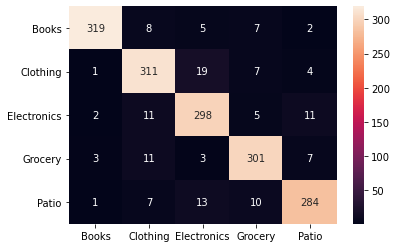

In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(x_test_vect)

labels = ['Books', 'Clothing', 'Electronics', 'Grocery', 'Patio']

cm = confusion_matrix(y_test, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

In [156]:
from sklearn.metrics import classification_report 
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       Books       0.94      0.98      0.96       326
    Clothing       0.91      0.89      0.90       348
 Electronics       0.91      0.88      0.90       338
     Grocery       0.93      0.91      0.92       330
       Patio       0.90      0.92      0.91       308

    accuracy                           0.92      1650
   macro avg       0.92      0.92      0.92      1650
weighted avg       0.92      0.92      0.92      1650

